In [ ]:
!pip install denoising_diffusion_pytorch
!pip install labml-nn

In [2]:

import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import random

from copy import deepcopy
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
from typing import Tuple, Optional, List
from tqdm import tqdm

# Torch imports
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision

from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets.folder import default_loader as loader 

# labml imports
from labml import lab, tracker, experiment, monit
from labml.configs import BaseConfigs, option
from labml_helpers.device import DeviceConfigs
from labml_nn.diffusion.ddpm import DenoiseDiffusion
from labml_nn.diffusion.ddpm.unet import UNet
# from labml_nn.diffusion.ddpm.experiment import Configs
from labml_nn.diffusion.ddpm.utils import gather

In [3]:
IMAGE_SIZE = 32

In [4]:

# Create a small trajectory as an image
class RandomTrajectory:
    def __init__(self, img_size, step_size, step_number):
        self.img_size = img_size
        self.step_size = step_size
        self.step_number = step_number
        self.curr_id = [0,0] # Indicates the index of the current point to add trajectory
        self.dir_probs = np.array([ # There are 9 possible directions, these are the probabilities of a direction
            [0.01, 0.05,0.11],
            [0.05, 0.01, 0.22], # Going right bottom has the highest probability
            [0.11, 0.22 ,0.22]
        ]).flatten()
        
        self.dirs = np.array([ # Directions of the indices in self.dir_probs correspondingly
            [-1,-1], [-1,0], [-1,+1], 
            [0, -1], [0, 0], [0, +1],
            [+1,-1], [+1,0], [+1,+1]
        ])

        self.frame_num = 0
        
    def reached_end(self):
        return self.curr_id[0] >= self.img.shape[0] or self.curr_id[1] >= self.img.shape[1]
        
    def reset(self):
        self.img = np.zeros((self.img_size, self.img_size)) # 1s will indicate the trajectory - input of the diffusion model will be a 1 channel img anyways
        self.curr_id = [0,0]
        
    def create_traj(self):
        self.reset()
        for _ in range(self.step_number):
            if self.reached_end():
                break
            self.img[self.curr_id[0], self.curr_id[1]] = 1
            self.add_step()
        # print("Trajectory planning finished")

        plt.imsave('diffusion_mock_dset/frame_{:05d}.jpg'.format(self.frame_num), self.img, cmap = plt.cm.gray)
        self.frame_num += 1
        # return deepcopy(self.img)
        
    def add_step(self):
        dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
        curr_dir = self.dirs[dir_id]
        while not self.is_dir_possible(curr_dir):
            dir_id = np.random.choice(len(self.dir_probs), 1, p=self.dir_probs)[0]
            curr_dir = self.dirs[dir_id] # All of the trajectories should be feasible
        self.curr_id += self.step_size * curr_dir
        
    def is_dir_possible(self, curr_dir):
        # Check the 1st axis
        is_pos = True
        for curr_ax in range(2):
            if self.curr_id[curr_ax] <= 0:
                if curr_dir[curr_ax] < 0:
                    is_pos = False
            elif self.curr_id[curr_ax] >= self.img_size-1:
                if curr_dir[curr_ax] > 0:
                    is_pos = False 
        return is_pos

    def plot(self, img=None, ax=None):
        plt.figure(figsize=(10,10))
        plt.imshow(self.img)


# rand_traj = RandomTrajectory(128, 1, 500)
# rand_traj.create_traj()
# rand_traj.plot()

In [10]:
# Create the dataset
rand_traj = RandomTrajectory(IMAGE_SIZE, 1, IMAGE_SIZE*3)
pbar = tqdm(total=10000)
for _ in range(10000):
    rand_traj.create_traj()
    pbar.update(1)

100%|██████████| 10000/10000 [00:53<00:00, 188.66it/s]


In [5]:
class RandTrajDataset(data.Dataset):
    def __init__(self, img_size):
        self.dataset_size = 10000
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.CenterCrop((img_size,img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))
        ])

    def _get_image(self, path):
        img = self.transform(loader(path))
        return torch.FloatTensor(img)

    def __len__(self):
        return self.dataset_size # Let's give this a try first

    def __getitem__(self, index):
        path = 'diffusion_mock_dset/frame_{:05d}.jpg'.format(index)
        # img = torch.FloatTensor([self.rand_trajs[index]])
        return self._get_image(path)

    # Method to plot random trajectories created
    def show(self, num_imgs=12):
        nrows = 3
        ncols = math.ceil(num_imgs / nrows)
        fig, axs = plt.subplots(figsize=(ncols*10,nrows*10), nrows=nrows, ncols=ncols)
        for i in range(num_imgs):
            axs_row = int(i / nrows)
            axs_col = int(i % nrows)

            rand_index = random.randint(0,self.dataset_size-1)
            img = self.__getitem__(rand_index).detach().numpy()

            axs[axs_col, axs_row].imshow(img[0])        



In [12]:
dataset = RandTrajDataset(IMAGE_SIZE)

# dataset.show(num_imgs=12)



In [13]:
dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

In [14]:
batch = next(iter(dataloader))
print('batch.shape: {}'.format(batch.shape))

batch.shape: torch.Size([8, 1, 32, 32])


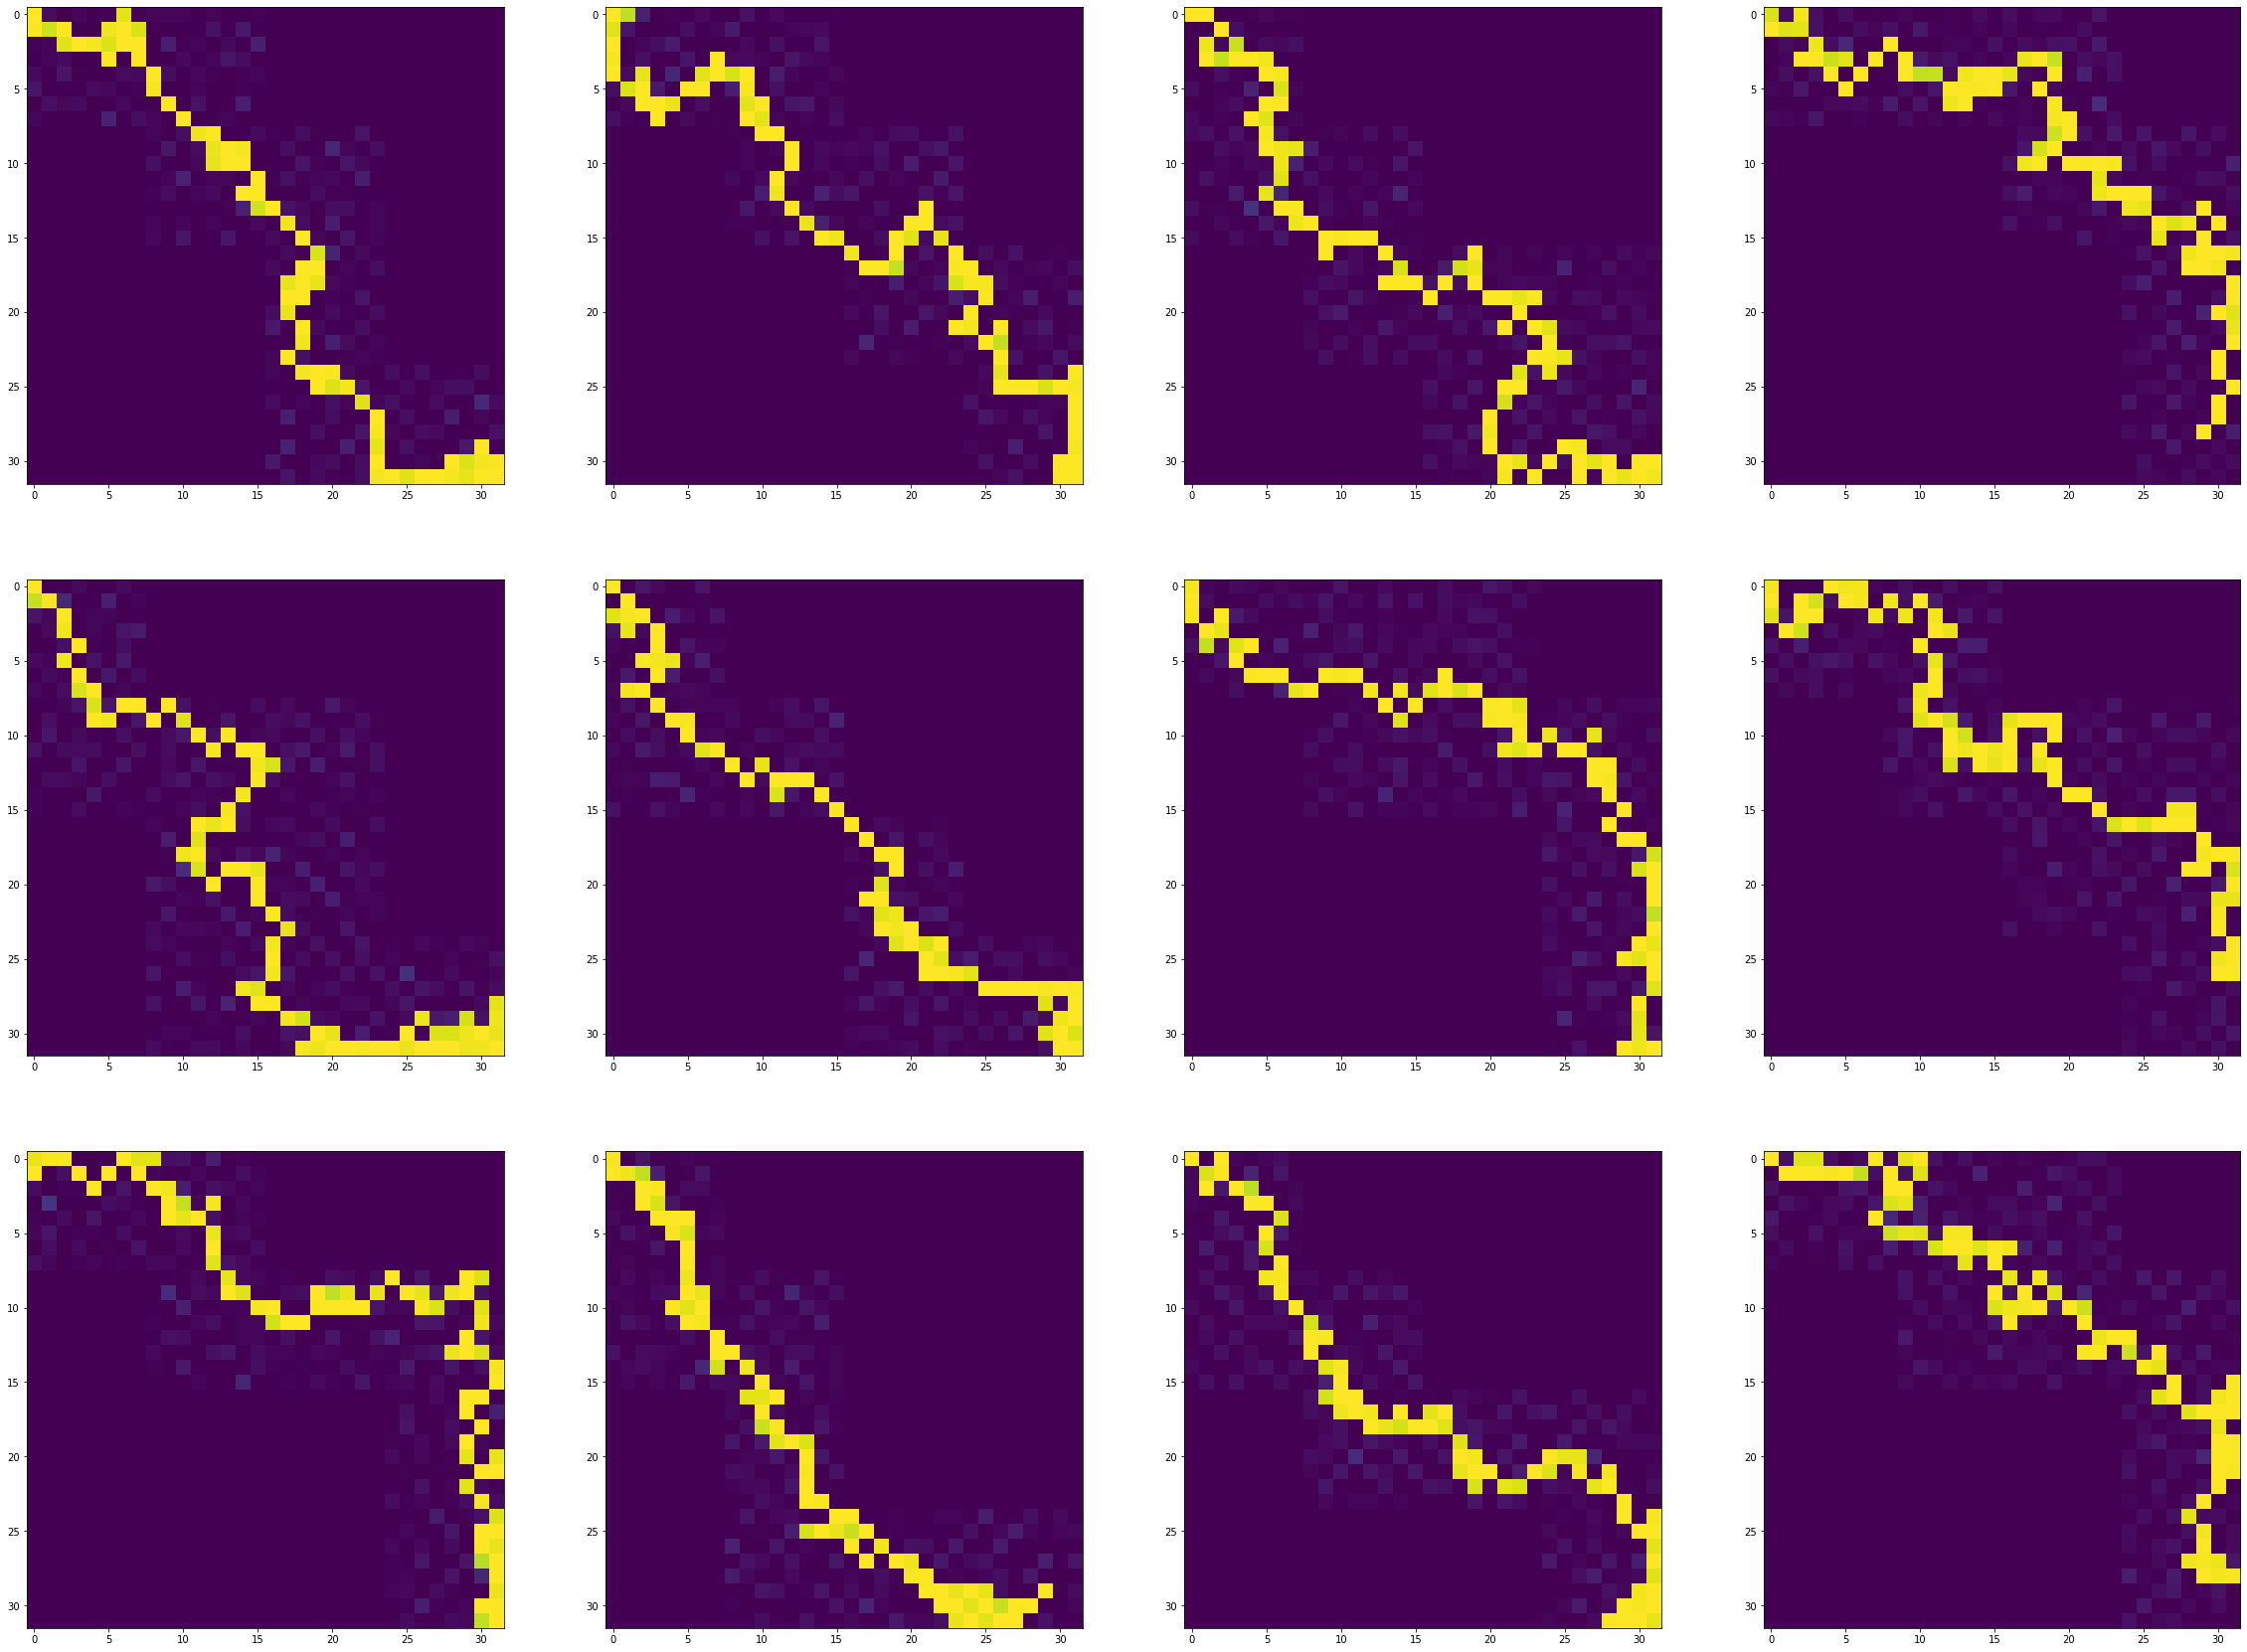

In [15]:
dataset.show()

In [ ]:
# model = Unet(
#     dim = 64,
#     dim_mults = (1, 2, 4, 8)
# )

# dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
# batch = next(iter(dataloader))
# print('batch.shape: {}'.format(batch.shape))

# diffusion = GaussianDiffusion(
#     model,
#     image_size = 128,
#     channels= 1,
#     timesteps = 1000,   # number of steps
#     loss_type = 'l1'    # L1 or L2
# )

# # training_images = torch.randn(8, 3, 128, 128) # images are normalized from 0 to 1
# loss = diffusion(batch)
# loss.backward()
# # after a lot of training

# sampled_images = diffusion.sample(batch_size = 4)
# sampled_images.shape # (4, 3, 128, 128)

In [ ]:



# class DenoiseDiffusion:
#     def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
#         super().__init__()
#         self.eps_model = eps_model
#         self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
#         self.alpha = 1. - self.beta
#         self.alpha_bar = torch.cumprod(self.alpha, dim=0)
#         self.n_steps = n_steps
#         self.sigma2 = self.beta

#     def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         mean = gather(self.alpha_bar, t) ** 0.5 * x0
#         var = 1 - gather(self.alpha_bar, t)
#         return mean, var

#     def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
#         if eps is None:
#             eps = torch.randn_like(x0)
#         mean, var = self.q_xt_x0(x0, t)
#         return mean + (var ** 0.5) * eps

#     def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
#         eps_theta = self.eps_model(xt, t)
#         alpha_bar = gather(self.alpha_bar, t)
#         alpha = gather(self.alpha, t)
#         eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
#         mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
#         var = gather(self.sigma2, t)

#         eps = torch.randn(xt.shape, device=xt.device)
#         return mean + (var ** .5) * eps

#     def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
#         batch_size = x0.shape[0]
#         t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

#         if noise is None:
#             noise = torch.randn_like(x0)

#         xt = self.q_sample(x0, t, eps=noise)
#         eps_theta = self.eps_model(xt, t)

#         return F.mse_loss(noise, eps_theta)

In [6]:
class Configs(BaseConfigs):
    """
    ## Configurations
    """
    # Device to train the model on.
    # [`DeviceConfigs`](https://docs.labml.ai/api/helpers.html#labml_helpers.device.DeviceConfigs)
    #  picks up an available CUDA device or defaults to CPU.
    device: torch.device = DeviceConfigs()
    # print('device: {}'.format(device))

    # U-Net model for $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$
    eps_model: UNet
    # [DDPM algorithm](index.html)
    diffusion: DenoiseDiffusion

    # Number of channels in the image. $3$ for RGB.
    image_channels: int = 3
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps $T$
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 1_000

    # Dataset
    dataset: torch.utils.data.Dataset
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        # Create [DDPM class](index.html)
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

        # Image logging
        tracker.set_image("sample", True)

    def sample(self):
        """
        ### Sample images
        """
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn([self.n_samples, self.image_channels, self.image_size, self.image_size],
                            device=self.device)

            # Remove noise for $T$ steps
            for t_ in monit.iterate('Sample', self.n_steps):
                # $t$
                t = self.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))

            # Log samples
            tracker.save('sample', x)

    def train(self):
        """
        ### Train
        """

        # Iterate through the dataset
        for data in monit.iterate('Train', self.data_loader):
            # Increment global step
            tracker.add_global_step()
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()
            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()
            # Take an optimization step
            self.optimizer.step()
            # Track the loss
            tracker.save('loss', loss)

    def run(self):
        """
        ### Training loop
        """
        pbar = tqdm(total=self.epochs)
        for _ in monit.loop(self.epochs):
            # Train the model
            self.train()
            # Sample some images
            self.sample()
            # New line in the console
            tracker.new_line()
            # Save the model
            experiment.save_checkpoint()
            pbar.update(1)


In [17]:
class MNISTDataset(torchvision.datasets.MNIST):
    """
    ### MNIST dataset
    """

    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__(str(lab.get_data_path()), train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]


@option(Configs.dataset, 'MNIST')
def mnist_dataset(c: Configs):
    """
    Create MNIST dataset
    """
    return MNISTDataset(c.image_size)

In [7]:
@option(Configs.dataset, 'RandTraj')
def randtraj_dataset(c: Configs):
    """
    Return the random trajectory dataset
    """

    return RandTrajDataset(c.image_size) # MNIST has 60k images

In [1]:

def main():
    # Create experiment
    experiment.create(name='diffuse', writers={'screen'})

    # Create configurations
    configs = Configs()

    # Set configurations. You can override the defaults by passing the values in the dictionary.
    experiment.configs(configs, {
        'dataset': 'RandTraj',  # 'MNIST'
        'image_channels': 1,  # 1,
        'image_size': IMAGE_SIZE,
        'epochs': 100,  # 5,
        'device': torch.device('cuda:0'),
    })

    # Initialize
    configs.init()

    # Set models for saving and loading
    experiment.add_pytorch_models({'eps_model': configs.eps_model})

    # Start and run the training loop
    with experiment.start():
        configs.run()


main()

NameError: name 'experiment' is not defined